# DATA 604 - Final Project: Simulating a PCP Clinic Process
## Stefano Biguzzi-Velcich
#### July 7, 2022


## Introduction

This project sets out to simulate a made up primary care practice clinic to best understand wait times and how to reduce them. The average wait time for a patient going to see a PCP is 18.17 minutes. Can this be reduced further? Is it possible without having to add too many new staff?

This project uses a couple assumptions:
1. About 15.8% of patients do not fill in a check in form online do to age or not having access to internet
2. About 53% of patients are coming for some preventative care visit that most likely doesn't require follow-up appointments
3. All processes follow a triangular distribution, i.e. check-in paper form, nurse visit, doctor visit, and follow up scheduling
4. All simulations are done over a course of a day or 480 minutes. This is to model a day at the clinic form 9AM to 5PM.


A lot of the data was taken from this report: [Primary Care in the United States A Chartbook of Facts and Statistics](https://www.graham-center.org/content/dam/rgc/documents/publications-reports/reports/PrimaryCareChartbook2021.pdf)

## PCP Clinic Flowchart

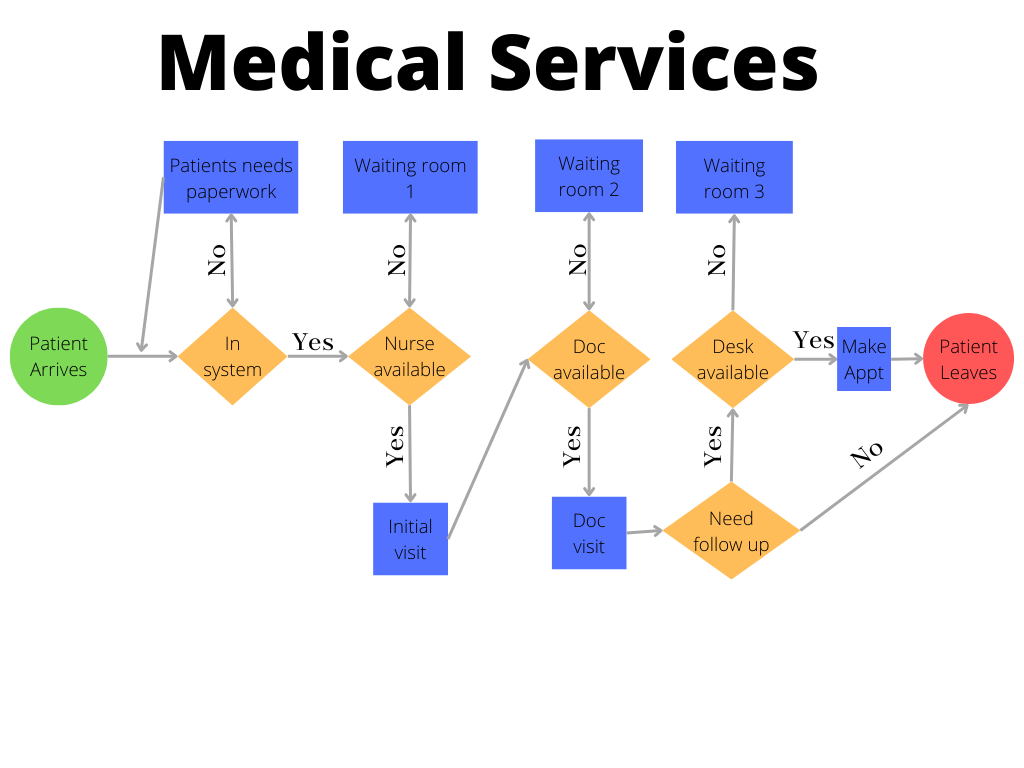

## Simulation Code

In [1]:
# Loading libraries
import simpy, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, math

In [2]:
# Create the clinic class
class Clinic(object):
    def __init__(self, env, num_doctors,num_nurses,num_admin_checkin,num_admin_checkout,p_in,p_out,random_seed):
        self.env = env
        # create the doctor resource
        self.doctor = simpy.Resource(env, num_doctors)
        # create the nurse resource
        self.nurse = simpy.Resource(env, num_nurses)
        # create the check in admin resource
        self.checkin_admin = simpy.Resource(env, num_admin_checkin)
        # create the check out admin resource
        self.checkout_admin = simpy.Resource(env, num_admin_checkout)
        # create the variable that stores the probability to check in via paper form
        self.p_in = p_in
        # create the variable that stores the probability for patient to require follow-up
        self.p_out = p_out
        # Set random seed for simulation
        self.seed = random_seed

In [3]:
# Define the clinic process
def go_to_clinic(env,patient,clinic):
    
    # set random seed for each simulation event
    np.random.seed(clinic.seed)
    
    # Patient arrives at the clinic
    arrival_time = env.now+np.random.triangular(0,2,15)
    
    # Check in process
    # chance patient did not fill in check in information online
    if np.random.choice([True,False],1,p=[clinic.p_in,1-clinic.p_in])[0]:
        # time it takes to fill out paper forms
        in_t = np.random.triangular(4,7,9)
    else:
        # general check in time
        in_t = np.random.exponential(1)
    
    with clinic.checkin_admin.request() as request:
        # patient in check in queue
        check_in_in = env.now
        # patient requests check in admin staff
        yield request
        # patient out of check in queue
        check_in_out = env.now
        # total wait time to check in
        check_in_wait =  check_in_out - check_in_in
        # check in process time
        yield env.timeout(in_t)
        # need to get things set up for new patient
        yield env.timeout(np.random.exponential(1))
    
    # nurse visit process
    # nurse visit time triangular distribution
    nurse_t = np.random.triangular(3,8,12)
    with clinic.nurse.request() as request:
        # patient in nurse queue
        nurse_in = env.now
        # time it takes nurse to get to patient in the room
        yield env.timeout(np.random.exponential(1.8))
        # request nurse
        yield request
        # time patient is out of nurse queue
        nurse_out = env.now
        # total wait time for nurse
        nurse_wait =  nurse_out - nurse_in
        # nurse visit process
        yield env.timeout(nurse_t)
        # time nurse fills out extra paperwork
        yield env.timeout(np.random.exponential(1.8))
        
    # doctor visit process
    # doctor visit time triangular distribution 
    doc_t = np.random.triangular(5,18,30)
    with clinic.doctor.request() as request:
        # patient in doctor queue
        doc_in = env.now
        # requesting doctor
        yield request
        # time it takes doctor to get to patient in the room
        yield env.timeout(np.random.exponential(1.8))
        # patient out of doctor queue
        doc_out = env.now
        # patient doctor wait time
        doctor_wait = doc_out - doc_in
        # doctor visit process
        yield env.timeout(doc_t)
        # time doctor fills out extra paperwork
        yield env.timeout(np.random.exponential(1.8))

    # Check-out process
    # chance patient has to schedule a follow up
    if np.random.choice([True,False],1,p=[clinic.p_out,1-clinic.p_out])[0]:
        # set check out time if patient needs follow up
        out_t = np.random.triangular(3,5,7)
    else:
        # set check out time if patient does not need follow up
        out_t = np.random.exponential(1)
        
    with clinic.checkout_admin.request() as request:
        # patient in check out queue
        checkout_in = env.now
        # requesting check out staff
        yield request
        # patient out of check out queue
        checkout_out = env.now
        # patient check out wait time
        check_out_wait = checkout_out - checkout_in
        # patient check out process
        yield env.timeout(out_t)
        # account for check out staff needing to do extra paper work before seeing new patient
        yield env.timeout(np.random.exponential(1))

    ## Metrics of interest
    # Patient length of stay
    visit_time.append(env.now - (arrival_time+check_in_wait+nurse_wait+doctor_wait+check_out_wait))
    # Patient check in time length
    check_in_time.append(in_t)
    # Patient check in wait time
    check_in_wait_time.append(check_in_wait)
    # Patient time with nurse
    nurse_time.append(nurse_t)
    # Patient waiting for nurse
    nurse_wait_time.append(nurse_wait)
    # Patient time with doctor
    doctor_time.append(doc_t)
    # Patient waiting for doctor
    doctor_wait_time.append(doctor_wait)
    # Patient time checking out
    check_out_time.append(out_t)
    # Patient check out wait time
    check_out_wait_time.append(check_out_wait)
    # Total wait time
    wait_time.append(check_in_wait+nurse_wait+doctor_wait+check_out_wait)
    
# Define clinic simulation process    
def run_clinic(env, num_doctors, num_nurses, num_admin_checkin, num_admin_checkout, p_in, p_out,pat_in,random_seed):
        
    # initiate clinic
    clinic = Clinic(env, num_doctors, num_nurses, num_admin_checkin, num_admin_checkout, p_in, p_out,random_seed)

    # initiate first patient
    for patient in range(1):
        env.process(go_to_clinic(env,patient,clinic))
        
    # continue with patients until run time
    while True:
        # wait for new patient to come in adding a early or late amount of minutes
        yield env.timeout(pat_in) 
        # increasing patient counts
        patient += 1
        # continue clinic process
        env.process(go_to_clinic(env,patient,clinic))

In [4]:
def clean_time(time_list):
    mean_time = np.mean(time_list)
    time_tuple = math.floor(mean_time),int((mean_time-math.floor(mean_time))*60)
    return print(str(time_tuple[0])+" min "+str(time_tuple[1])+" sec")

### Validity Model

In [5]:
DOCTOR_V = 2
NURSE_V = 2
CHECKIN_ADMIN_V = 1
CHECKOUT_ADMIN_V = 1
PAT_TIME_V = 10
RANDOM_SEED_V = 100

# start dictionary to keep wait times seperated by day
wait_times_V = {}
doctor_times_V = {}
nurse_times_V = {}

# Simulate model over the course of one work year (only workdays)
for i in range(260):
    
    # Set random seed for each simulation run
    RANDOM_SEED_V += i
    
    # Initiate data monitoring
    check_in_time = []
    check_in_wait_time = []
    nurse_wait_time = []
    nurse_time = []
    doctor_wait_time = []
    doctor_time = []
    check_out_wait_time = []
    check_out_time = []
    wait_time = []
    visit_time = []
    
    # Run simulation
    env = simpy.Environment()
    env.process(run_clinic(env, DOCTOR_V,NURSE_V,CHECKIN_ADMIN_V,CHECKOUT_ADMIN_V,0.158,0.47,PAT_TIME_V,RANDOM_SEED_V))
    env.run(until=480)
    
    # update the wait time dictionary
    wait_times_V.update({i:wait_time})
    doctor_times_V.update({i:doctor_time})
    nurse_times_V.update({i:nurse_time})
    
# Compile yearly wait times
mean_wait_time_V = {}
for k,v in wait_times_V.items():
    mean_wait_time_V.update({k:np.mean(v)})
    
new_wait_time_V = []
for x in list(wait_times_V.values()):
    new_wait_time_V += x

# Compile yearly doctor visit time
mean_doctor_time_V = {}
for k,v in doctor_times_V.items():
    mean_doctor_time_V.update({k:np.mean(v)})
    
new_doctor_time_V = []
for x in list(doctor_times_V.values()):
    new_doctor_time_V += x
    
    
# Compile yearly wait times
mean_nurse_time_V = {}
for k,v in nurse_times_V.items():
    mean_nurse_time_V.update({k:np.mean(v)})
    
new_nurse_time_V = []
for x in list(nurse_times_V.values()):
    new_nurse_time_V += x

In [6]:
## Graphing daily mean wait times for validity model
fig = plt.figure() 
# Figure size
fig.set_size_inches(8,6)
plt.plot(mean_wait_time_V.keys(),mean_wait_time_V.values())
plt.axhline(y=np.mean(new_wait_time_V), color='r', linestyle='dashed')
plt.title('Daily mean wait times over a year')
plt.xlabel('Day')
plt.ylabel('Time')

plt.savefig('validity-fig01.png')
plt.close()

In [7]:
## Graphing doctor visit time histogram for validity model
fig = plt.figure() 
# Figure size
fig.set_size_inches(8,6)
plt.hist(new_doctor_time_V,25)
plt.axvline(x = np.mean(new_doctor_time_V), color = 'r', linestyle = 'dashed', label = 'axvline - full height')
plt.title('Histogram of doctor visit time')
plt.xlabel('Time - min')
plt.ylabel('Freq')
plt.savefig('validity-fig02.png')
plt.close()

Looking at the wait times for the year in the graph below we can see that the wait times are failry random. There are some days when the the wait average wait time can go up to 80 minutes and other days when the average wait time is as low as 5 minutes. However, the average wait times at this PCP clinic is 23 minutes and 51 seconds. This is right around the average for the American pcp clinics of around 18 to 20 minutes found from this [First Stop Health](https://www.fshealth.com/blog/how-much-time-does-doctor-visit-really-take) article. The simulation seems to be a good fit, given that the model is producing similar wait times to what's been seen in the real world.
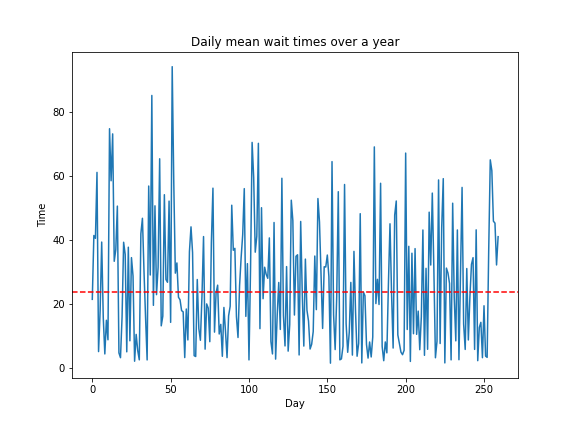
Additionally, we can look at the average visit times for patients with doctors in this clinic and compare it to the real world average of about 18 min, found on this [Healio](https://www.healio.com/news/primary-care/20210121/average-primary-care-exam-lasts-less-than-20-minutes) article. After simulating the data for a year we get the average time a patient spends with a doctor to be 17 min and 41 seconds, as seen in the graph below. That is right around the real world visit time, which means both the triangular distribution is an accurate representation of the doctor visit time and the model is again similar to real world data making it a valid model to use to model a PCP clinic.

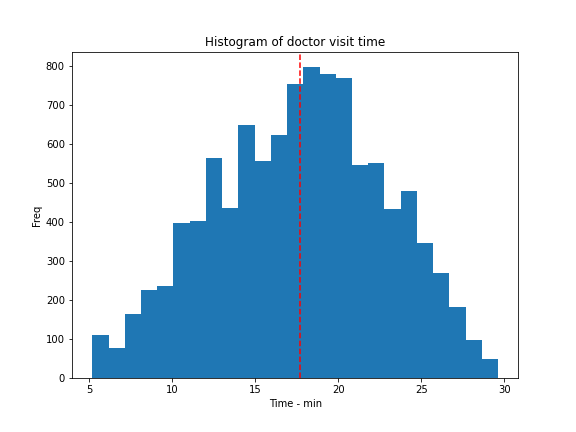

### Model A - Equal doctors and nurses; patients scheduled every 10 minutes

*This is a subsection of one day from the validity model*

In [8]:
DOCTOR_A = 2
NURSE_A = 2
CHECKIN_ADMIN_A = 1
CHECKOUT_ADMIN_A = 1
PAT_TIME_A = 10
RANDOM_SEED_A = 100

# Initiate data monitoring
check_in_time = []
check_in_wait_time = []
nurse_wait_time = []
nurse_time = []
doctor_wait_time = []
doctor_time = []
check_out_wait_time = []
check_out_time = []
wait_time = []
visit_time = []

# Run simulation
env = simpy.Environment()
env.process(run_clinic(env, DOCTOR_A,NURSE_A,CHECKIN_ADMIN_A,CHECKOUT_ADMIN_A,0.158,0.47,PAT_TIME_A,RANDOM_SEED_A))
env.run(until=480)

# Set model A metric monitoring
nurse_time_A = nurse_time
nurse_wait_time_A = nurse_wait_time
doctor_wait_time_A = doctor_wait_time
wait_time_A = wait_time

# set up dataframe to graph model
df_A = pd.DataFrame({'WaitTimes':wait_time_A,'DocWait':doctor_wait_time_A,'NurseWait':nurse_wait_time_A})

In [9]:
# Graph metric for model A
fig = plt.figure()
# Figure size
fig.set_size_inches(9,7)

plt.plot(df_A.index, df_A.WaitTimes, label = "Total Wait Time")
plt.plot(df_A.index, df_A.DocWait, label = "Doctor Wait Time")
plt.plot(df_A.index, df_A.NurseWait, label = "Nurse Wait Time")
plt.title('Metrics for Model A')
plt.xlabel('Patient ID')
plt.ylabel('Time')
plt.legend()
plt.savefig('findings-fig1.png')
plt.close()

### Model B - +1 doctors and -1 nurse; patients scheduled every 10 minutes

In [10]:
DOCTOR_B = 3
NURSE_B = 1
CHECKIN_ADMIN_B = 1
CHECKOUT_ADMIN_B = 1
PAT_TIME_B = 10
RANDOM_SEED_B = 55

# Initiate data monitoring
check_in_wait_time = []
nurse_wait_time = []
doctor_wait_time = []
doctor_time = []
check_out_wait_time = []
wait_time = []
visit_time = []

# Run simulation
env = simpy.Environment()
env.process(run_clinic(env, DOCTOR_B,NURSE_B,CHECKIN_ADMIN_B,CHECKOUT_ADMIN_B,0.158,0.47,PAT_TIME_B,RANDOM_SEED_B))
env.run(until=480)

# Set model A metric monitoring
nurse_time_B = nurse_time
nurse_wait_time_B = nurse_wait_time
doctor_wait_time_B = doctor_wait_time
wait_time_B = wait_time

# set up dataframe to graph model
df_B = pd.DataFrame({'WaitTimes':wait_time_B,'DocWait':doctor_wait_time_B,'NurseWait':nurse_wait_time_B})

In [11]:
# Graph metric for model B

fig = plt.figure()
# Figure size
fig.set_size_inches(9,7)

plt.plot(df_B.index, df_B.WaitTimes, label = "Total Wait Time")
plt.plot(df_B.index, df_B.DocWait, label = "Doctor Wait Time")
plt.plot(df_B.index, df_B.NurseWait, label = "Nurse Wait Time")
plt.title('Metrics for Model B')
plt.xlabel('Patient ID')
plt.ylabel('Time')
plt.legend()
plt.savefig('findings-fig2.png')
plt.close()

## Findings

Looking at the wait time results for a given day at a clinic with 2 doctors, 2 nurses, 1 admin check in staff, and 1 admin check out staff and patients scheduled for every 10 minutes we see that the doctor's wait time is extremely related to the wait time, more so than the nurse wait time. This is clear in the *Metrics for Model A* graph below. The doctor wait time follows the total wait time much closer than the nurse wait time. This is probably do to the average nurse time being 4 min and 30 seconds for Model A, and 7 minutes 38 seconds for a full year (the validity model). Since this is less than the time that each patient is scheduled to come into the office, it makes sense that doctor's are in higher need. 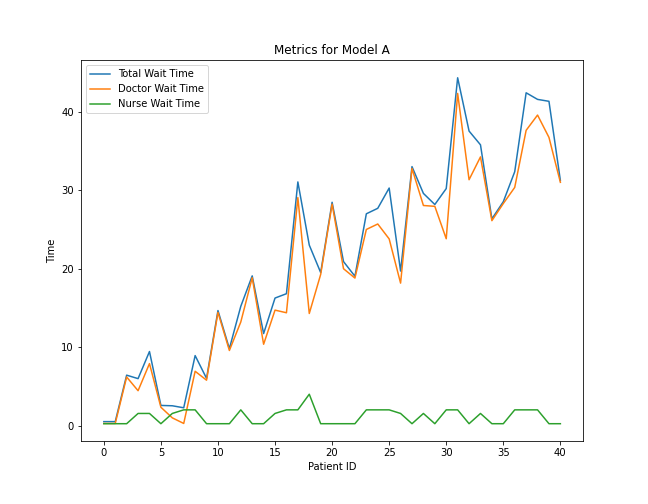

Model B we tried to offset this relationship be reducing the number of nurses by 1 and adding an extra doctor giving the clinic a 3:1 doctor to nurse ration rather than a 1:1 ratio. Looking at the graph below, *Metrics for Model B*, we can see that changing the ratio creates a better looking wait time graph where the wait times are more evenly spread between nurse and doctor. Doctor wait time decreased from 19 minutes and 36 seconds on average to 1 minute and 35 seconds. We do increase the nurse wait time from 1 min and 6 seconds to 5 min and 24 seconds on average. However, this increase still reduces patient wait times to 7 minutes and 57 seconds on average, which is still better than the 21 minutes and 25 seconds from Model A.
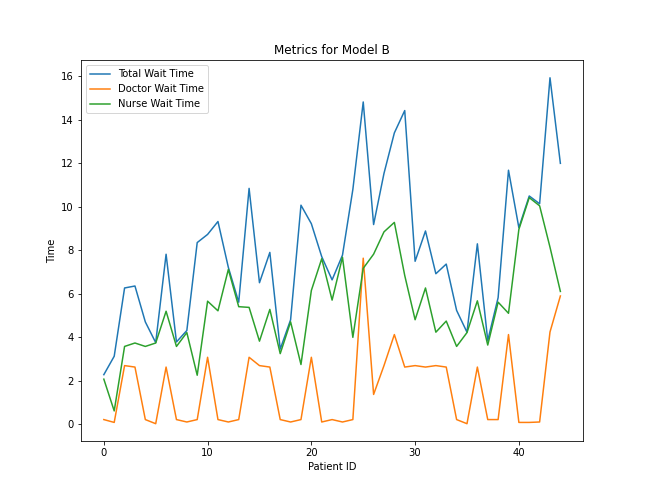

Future studies would be intersting to consider cost of having an extra doctor versus a nurse as since it might not be beneficial to higher another docotr, unless you have more patients, but that might no reduce wait times and would not have a benefit on reducing wait times.